In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im
import rasterio

In [2]:
satellite_path = './satellite.jpg'
img = cv2.imread(satellite_path)

In [10]:
def show_cv2_img(img):
    plt.imshow(img)
    plt.colorbar()
    plt.show()

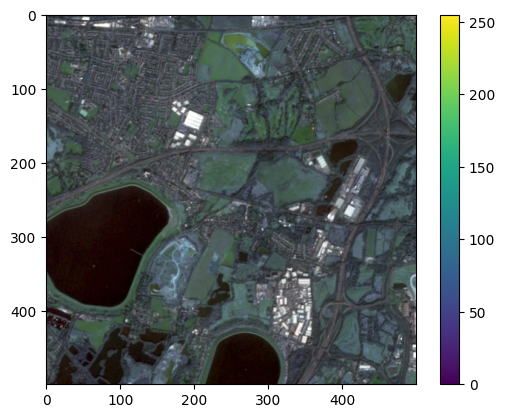

In [11]:
show_cv2_img(img)

In [6]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

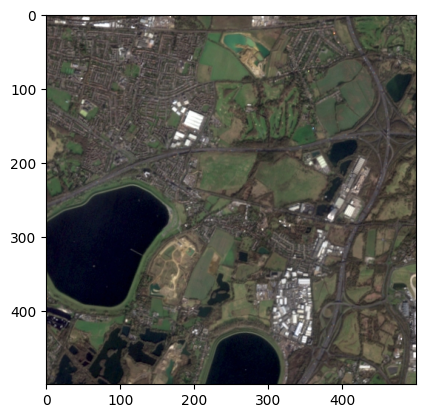

In [7]:
show_cv2_img(img_rgb)

In [8]:
lidar_path = './lidar.tif'
lidar = rasterio.open(lidar_path)
lidar_img = lidar.read(1)

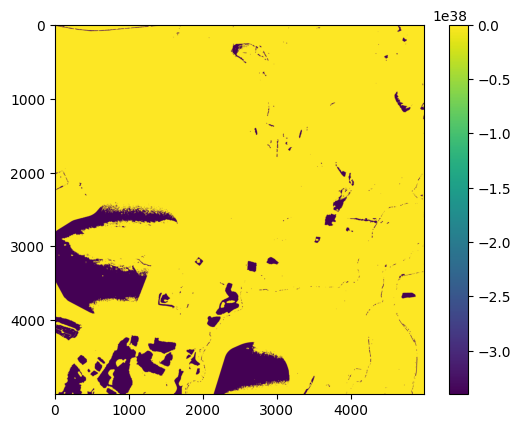

In [12]:
show_cv2_img(lidar_img)

In [13]:
def normalise_lidar_data(lidar_img):
    lidar_img = lidar_img - np.min(lidar_img)
    lidar_img = lidar_img / np.max(lidar_img)
    return lidar_img

In [14]:
normalised_lidar_img = normalise_lidar_data(lidar_img)

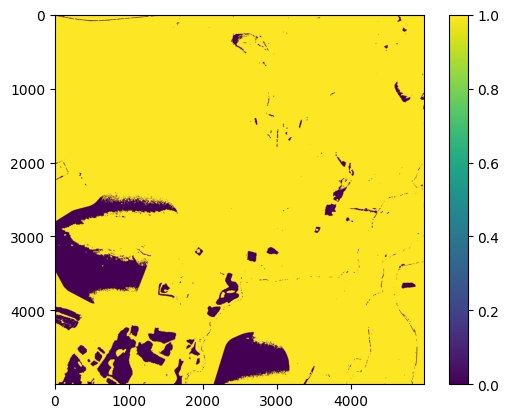

In [15]:
show_cv2_img(normalised_lidar_img)

In [16]:
def resize_img1_to_img2(img1, img2):
    return cv2.resize(img1, (img2.shape[1], img2.shape[0]))

In [17]:
resized_lidar = resize_img1_to_img2(normalised_lidar_img, img_rgb)

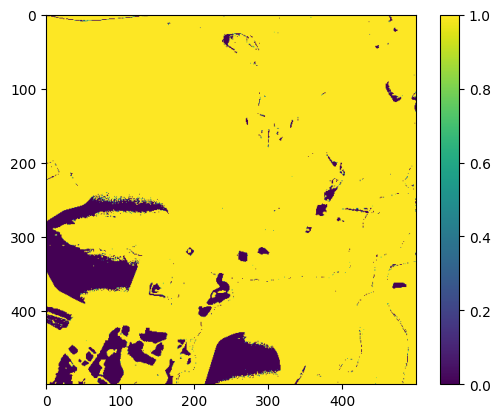

In [18]:
show_cv2_img(resized_lidar)

In [19]:
from matplotlib.widgets import Slider, Button

def interactive_lidar_visualization(lidar_data):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.subplots_adjust(left=0.1, bottom=0.3)
    
    # Get initial data range
    data_min = np.min(lidar_data)
    data_max = np.max(lidar_data)
    
    # Initial parameters
    init_min = data_min
    init_max = data_max
    init_gamma = 1.0
    
    # Create initial normalized image
    normalized = (lidar_data - init_min) / (init_max - init_min)
    normalized = np.clip(normalized, 0, 1)
    normalized = normalized ** init_gamma
    
    # Display image
    img_display = ax.imshow(normalized, cmap='viridis')
    fig.colorbar(img_display, ax=ax)
    ax.set_title('LiDAR Data Normalization')
    
    # Create slider axes
    ax_min = plt.axes([0.1, 0.2, 0.8, 0.03])
    ax_max = plt.axes([0.1, 0.15, 0.8, 0.03])
    ax_gamma = plt.axes([0.1, 0.1, 0.8, 0.03])
    ax_reset = plt.axes([0.8, 0.025, 0.1, 0.04])
    
    # Create sliders
    min_slider = Slider(ax_min, 'Min Value', data_min, data_max, valinit=init_min)
    max_slider = Slider(ax_max, 'Max Value', data_min, data_max, valinit=init_max)
    gamma_slider = Slider(ax_gamma, 'Gamma', 0.1, 3.0, valinit=init_gamma)
    reset_button = Button(ax_reset, 'Reset')
    
    # Update function
    def update(val=None):
        min_val = min_slider.val
        max_val = max_slider.val
        gamma = gamma_slider.val
        
        # Ensure min < max
        if min_val >= max_val:
            min_val = max_val - (data_max - data_min) * 0.01
            min_slider.set_val(min_val)
            return
            
        # Normalize data based on slider values
        normalized = (lidar_data - min_val) / (max_val - min_val)
        normalized = np.clip(normalized, 0, 1)
        normalized = normalized ** gamma
        
        # Update display
        img_display.set_array(normalized)
        fig.canvas.draw_idle()
    
    # Reset function
    def reset(event):
        min_slider.reset()
        max_slider.reset()
        gamma_slider.reset()
        
    # Connect callbacks
    min_slider.on_changed(update)
    max_slider.on_changed(update)
    gamma_slider.on_changed(update)
    reset_button.on_clicked(reset)
    
    plt.show()
    return fig, (min_slider, max_slider, gamma_slider)

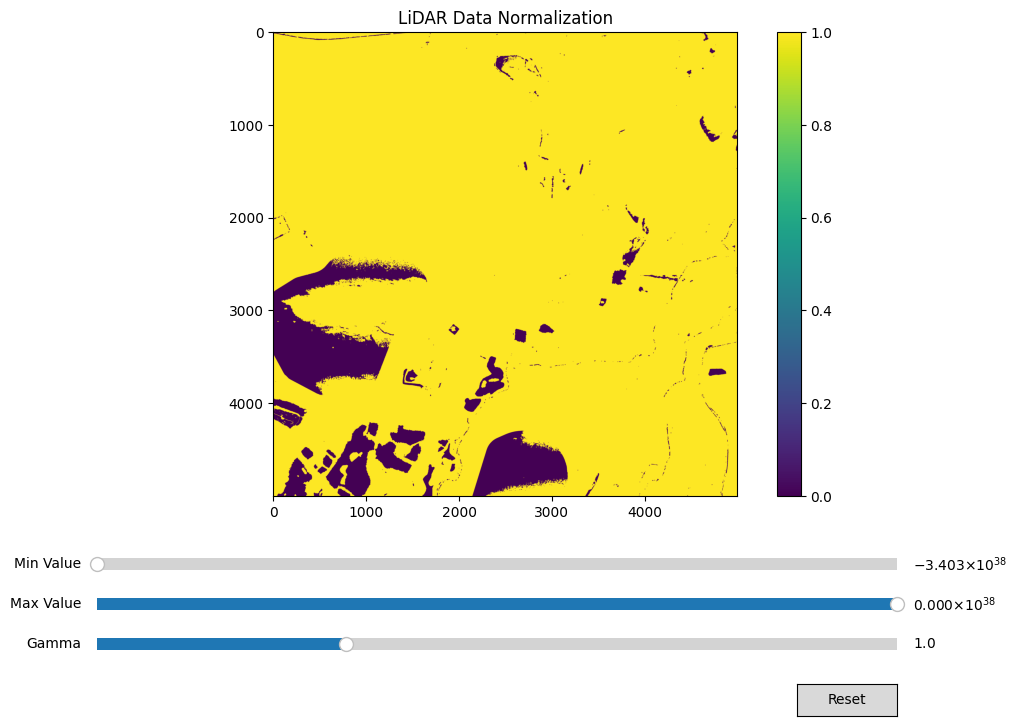

(<Figure size 1000x800 with 6 Axes>,
 (<matplotlib.widgets.Slider at 0x7e5bebf08be0>,
  <matplotlib.widgets.Slider at 0x7e5c00be1750>))

In [20]:
interactive_lidar_visualization(lidar_img)